# Anovos Use Case - US Police Shooting Data

## Table of Contents
- [Introduction](#Introduction)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Data Transformation](#Data-Transformation)
- [Summary](#Summary)

## Introduction
Anovos is an open source library for feature engineering at scale. It covers various essential steps in ML pipeline such as exploratory data analysis, anomaly detection, missing value imputation, categorical encoding, drift detection etc.
![anovos](../use_case_demo/assets/img/anovos_intro.png)

### Objective
In this notebook, we will use Anovos to analyze the US Police Shootings Data from [Kaggle](https://www.kaggle.com/datasets/ramjasmaurya/us-police-shootings-from-20152022) with a special focus on geospatial analysis.

### Resources
Throughout the demo, you may find the following resources helpful:
* API documentation: https://docs.anovos.ai/api/
* Example notebooks: https://github.com/anovos/anovos/tree/main/examples/notebooks

### Setting up
Before all the analysis, let's set up the working environment. 

Environment set up involves installing anovos by pip method which will ensure all dependencies are rightly installed in your local working environment

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# (Optional) you can install Anovos by running the following command:
#!pip install anovos

In [4]:
# Setup the SparkSession
from anovos.shared.spark import spark, sc
sc.setLogLevel('ERROR')

In [5]:
input_path = "./data/"
output_path = "./data/output/"

### Load the data
The [dataset](https://www.kaggle.com/datasets/ramjasmaurya/us-police-shootings-from-20152022) is originally taken from Kaggle but tweaked slightly to showcase the geospatial functionalities of Anovos. To conduct geospatial analysis, it is required to remove all null values in geospatial fields.

In [6]:
from anovos.data_ingest.data_ingest import read_dataset
df = read_dataset(spark, file_path=input_path+'shootings_modified.csv',
                  file_type='csv', file_configs={'header': 'True', 'delimiter': ',', 'inferSchema': 'True'})
df = df.drop("date", "name")
df.limit(5).toPandas()

id   manner_of_death       armed  age gender race           city state  \
0   1              shot         gun   53      M    A        Shelton    WA   
1   2              shot         gun   47      M    W          Aloha    OR   
2   3  shot and Tasered     unarmed   23      M    H        Wichita    KS   
3   4              shot  toy weapon   32      M    W  San Francisco    CA   
4   5              shot    nail gun   39      M    H          Evans    CO   

   signs_of_mental_illness threat_level         flee  body_camera  longitude  \
0                     True       attack  Not fleeing        False   -123.122   
1                    False       attack  Not fleeing        False   -122.892   
2                    False        other  Not fleeing        False    -97.281   
3                     True       attack  Not fleeing        False   -122.422   
4                    False       attack  Not fleeing        False   -104.692   

   latitude  is_geocoding_exact  
0    47.247                True  
1    45.487                True  
2    37.695                True  
3    37.763                True  
4    40.384                True

## Exploratory Data Analysis (EDA)
EDA is an important step in feature engineering. Anovos can perform EDA in 2 ways: a) By leveraging the auto-generated reports, and b) By calling individual functions from `data_analyzer` module.

### EDA using auto-generated reports
`data_report` module can auto-generate 2 types of HTML reports: basic report and full report.

The **basic report** contains the following components:
- Descriptive Statistics
- Quality Checks - missing values, outliers, invalid entries, etc
- Attribute Associations

The **full report** contains the components provided in the basic report and the following:
- Executive Summary
- Wiki: data and metric dictionaries
- Attribute Visualizations
- Data Drift & Stability Index (if applicable)
- Timeseries Analysis (if applicable)
- Geopspatial Analysis (if applicable)

#### Basic report
`anovos_basic_report` function from data_report/basic_report_generation can be used to generate the basic report. 

*Input* <br>
ID & Label columns can be passed through arguments (id_col and label_col) if they are available. If they are not mentioned, the basic report can still be generated but there will be no insights related to information value and information gain under Attribute Associations section.

In the dataset we are currently working on, `id` (ID of the shooting case) is the ID column so we can specify it in the function call.

*Output* <br>
A pre-saved report can be found in folder **assets/reports/basic_report.html** for your reference. <br>
You can also generate the same report by running the cell below. After it finishes running, an HTML report will be opened automatically in the browser. If you are unable to load the web page in Safari, you may try using Chrome instead. The report is also accessable at _data/output/data_report/report_stats/basic_report.html_. For Docker, please download the report and open using browser.

In [8]:
from anovos.data_report.basic_report_generation import anovos_basic_report
report_path = output_path+"data_report/report_stats/"
id_col = "id"
#Option 1 (with ID Column)
anovos_basic_report(spark, df, id_col, output_path=report_path, print_impact=False)
#Option 2 (without ID Column)
#anovos_basic_report(spark, df, skip_corr_matrix=True, output_path=report_path, print_impact=False)

No. of Rows: 6892
No. of UNIQUE Rows: 6892
No. of Duplicate Rows: 0
Percentage of Duplicate Rows: 0.0


+---------+--------------+--------------+------------------------+
|attribute|lower_outliers|upper_outliers|excluded_due_to_skewness|
+---------+--------------+--------------+------------------------+
|latitude |0             |44            |0                       |
|longitude|0             |0             |0                       |
|age      |0             |69            |0                       |
|id       |0             |0             |0                       |
+---------+--------------+--------------+------------------------+



App saved to ././data/output/data_report/report_stats/basic_report.html

----------
Before generating the  full report with geospatial analysis, it is pre-requisite to call `anovos_basic_report`, `geospatial_autodetection` and `charts_to_objects` to detect geospatial fields, generated geospatial visualizations and convert all charts to objects. Instead of calling `anovos_basic_report`, alternatively we can call the individual functions and save the statistics in report_path (master_path)

In [11]:
report_stats_path = input_path+'pre_saved_stats/report_stats/'
max_cluster = 20
eps = "0.1,0.9,0.05"
min_samples = "500,1100,100"
global_map_box_val = 0
max_records = 100000
run_type = "local"
auth_key = "NA"
top_geo_records=100

In [12]:
from anovos.data_analyzer.geospatial_analyzer import geospatial_autodetection
lat_cols, long_cols, gh_cols = geospatial_autodetection(df, id_col, report_path, max_records, top_geo_records, max_cluster, eps,
                                                        min_samples, global_map_box_val, run_type=run_type, auth_key=auth_key)
lat_cols, long_cols, gh_cols

2022-11-23 22:21:38,555 INFO [clientserver]: Closing down clientserver connection


(['latitude'], ['longitude'], [])

#### Full report
A pre-saved full report can be found in folder **assets/reports/ml_anovos_report.html** for your reference.

`anovos_report` can be used to generate the full report. An HTML report will be opened automatically after running the cell below. Again, you may use Chrome if Safari cannot load the page. The report will also be accessable at _data/output/data_report/ml_anovos_report.html_. For Docker, please download the report and open using browser.

Since data for Drift & Stability tab are not available, the argument `drift_detector` is set to False when calling `anovos_report`.

In [32]:
from anovos.data_report.report_preprocessing import charts_to_objects
from anovos.data_report.report_generation import anovos_report
charts_to_objects(spark, df, list_of_cols='all', drop_cols=id_col, 
                  source_path=report_stats_path, drift_detector=False, master_path=report_path)

anovos_report(report_path, id_col=id_col, lat_cols=lat_cols, long_cols=long_cols, 
              gh_cols = gh_cols, final_report_path=output_path+"data_report/")

2022-11-23 22:28:10.456 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:580 - processing failed, error [Errno 2] No such file or directory: './data/output/data_report/report_stats/freqDist_None'
2022-11-23 22:28:10.473 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:730 - processing failed, error [Errno 2] No such file or directory: './data/output/data_report/report_stats/correlation_matrix.csv'
2022-11-23 22:28:10.474 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:743 - processing failed, error [Errno 2] No such file or directory: './data/output/data_report/report_stats/IV_calculation.csv'
2022-11-23 22:28:10.474 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:751 - processing failed, error 'NoneType' object is not iterable
2022-11-23 22:28:10.474 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:751 - processing failed, error 'NoneType' object is not iterable
2022-11

App saved to ././data/output/data_report/ml_anovos_report.html

Report generated successfully at the specified location


### EDA using data_analyzer module's geospatial analyzer
Different components in reports can also be generated through individual function calls (listed below). Please refer to [Anovos documentation](https://docs.anovos.ai/api/data_analyzer/index.html) for more information.

**Stats Generator**
- global_summary
- measures_of_counts
- measures_of_centralTendency
- measures_of_cardinality
- measures_of_dispersion
- measures_of_percentiles
- measures_of_shape

**Quality Checkers**
- duplicate_detection
- nullRows_detection
- nullColumns_detection
- outlier_detection
- IDness_detection
- biasedness_detection
- invalidEntries_detection 

*These functions also provides different treatment options to fix those quality issues!*


**Attribute Associations**
- correlation_matrix
- variable_clustering
- IV_calculation
- IG_calculation

**Geospatial Analyzer**
- descriptive_stats_gen
- lat_long_col_stats_gen
- geohash_col_stats_gen
- stats_gen_lat_long_geo
- geo_cluster_analysis
- geo_cluster_generator
- generate_loc_charts_processor
- generate_loc_charts_controller
- geospatial_autodetection

-------------------------
In this notebook, we will demonstrate a few Geospatial Analyzer functions.

#### Descriptive Statsitics of Geospatial Fields
`stats_gen_lat_long_geo` provides decriptive statistics for geospatial fields by analyzing each latitude-longitude pair and geoahsh columns separately.
In this example, we will also show how to generate these statistics for the shootings dataset.

In [14]:
from anovos.data_analyzer.geospatial_analyzer import stats_gen_lat_long_geo

In [15]:
stats_gen_lat_long_geo(df, lat_cols, long_cols, gh_cols, id_col, report_path, max_val = top_geo_records)

Since the dataset does not have geohash column, this function will trigger analysis on latitude-longitude pairs only and generate 2 files for each pair stored in report_path:
- Overall_Summary_1_latitude_longitude
- Top_100_Lat_long_1_latitude_longitude (since max_val = 100)

In [17]:
import pandas as pd

In [18]:
# Output 1 - Descriptive Statistics
odf_summary_latlon = pd.read_csv(report_path+"/Overall_Summary_1_{}.csv".format(lat_cols[0]+"_"+long_cols[0]))
odf_summary_latlon.head()

Stats             Count
0               Distinct {Lat, Long} Pair              6820
1                       Distinct Latitude              5330
2                      Distinct Longitude              6031
3            Most Common {Lat, Long} Pair  [40.442,-79.882]
4  Most Common {Lat, Long} Pair Occurence                 3

In [20]:
# Output 2 - Top latitude-longitude pairs
odf_top_lat_long = pd.read_csv(report_path+"/Top_{}_Lat_Long_1_{}.csv".format(top_geo_records,lat_cols[0]+"_"+long_cols[0]))
odf_top_lat_long

lat_long_pair  count_id  count_records
0   [33.378,-111.978]         3              3
1    [40.442,-79.882]         3              3
2   [47.606,-122.332]         3              3
3   [61.581,-149.439]         2              2
4    [36.607,-83.714]         2              2
..                ...       ...            ...
95   [44.844,-91.523]         1              1
96   [40.505,-81.641]         1              1
97  [33.892,-117.331]         1              1
98  [34.438,-116.832]         1              1
99   [29.725,-95.442]         1              1

[100 rows x 3 columns]

If geohash columns are available in input dataset, 2 output tables will be generated for each geohash column:
- Overall_Summary_2_geohash
- Top_100_Geohas_Distribution_2_geohash (since max_val = 100)

#### Cluster Analysis of Geospatial Fields
`geo_cluster_generator` conducts clustering on datapoints using K-Means and DBSCAN algorithms for each latitude-longitude pair and geohash column respectively. We will demonstrate to use `geo_cluster_generator` on geospatial fields.

In [21]:
from anovos.data_analyzer.geospatial_analyzer import geo_cluster_generator

In [374]:
geo_cluster_generator(df,lat_cols, long_cols, gh_cols, max_cluster, eps, min_samples, 
                      report_path, global_map_box_val, max_records)

In addition to `lat_cols`, `long_cols` and `gh_cols`, we have to specify below parameters when calling `geo_cluster_generator`:
- `max_clusters`: Maximum number of iterations to decide on the optimum cluster
- `eps`: Epsilon value range (Min EPS, Max EPS, Interval) used for DBSCAN clustering
- `min_samples`: Minimum Sample Size range (Min Sample Size, Max Sample Size, Interval) used for DBSCAN clustering
- `global_map_box_val`: Geospatial Chart Theme Index
- `max_records`: Maximum geospatial points analyzed

The `geo_cluster_generator` function would generated 8 figures for each latitude-longitude pair or geohash column, and stored them as JSON objects inside `report_path`. Since this dataset only contains 1 latitude-longitude pair, 8 JSON files are generated:
- cluster_plot_1_elbow_latitude_longitude
- cluster_plot_1_silouhette_latitude_longitude
- cluster_plot_2_dbscan_latitude_longitude
- cluster_plot_2_kmeans_latitude_longitude
- cluster_plot_3_dbscan_latitude_longitude
- cluster_plot_3_kmeans_latitude_longitude
- cluster_plot_4_dbscan_1_latitude_longitude
- cluster_plot_4_dbscan_2_latitude_longitude

We and we will demonstrate how to view the plots via `plotly` library, which allows interactive zoom-in and zoom-outs.

In [22]:
import plotly

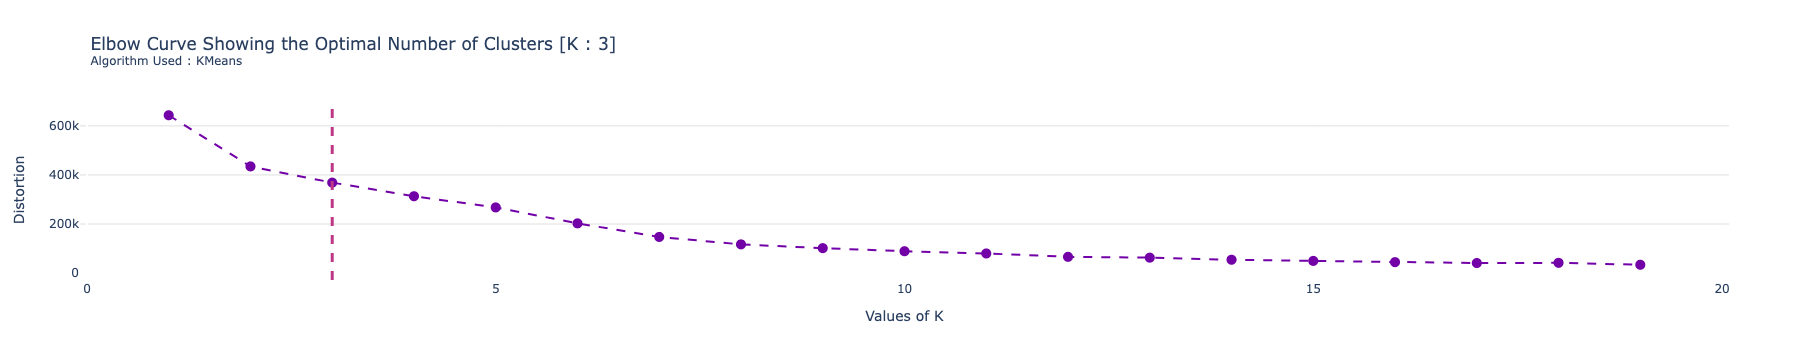

In [23]:
plotly.io.read_json(report_path+"/cluster_plot_1_elbow_{}".format(lat_cols[0]+"_"+long_cols[0]))

The first plot is the Distortion by K-values plots to show the optimal number of clusters found via K-Means algorithm. We have conducted K-Means clustering using 1,2, ..., 20 clusters, and found out K=3 is the best case for this dataset.

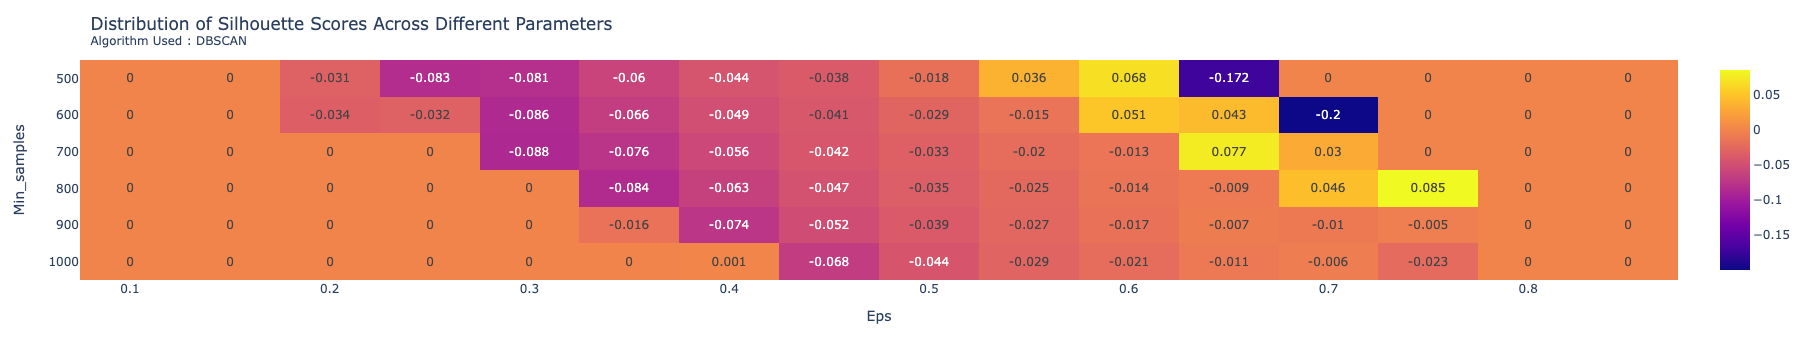

In [24]:
plotly.io.read_json(report_path+"/cluster_plot_1_silhoutte_{}".format(lat_cols[0]+"_"+long_cols[0]))

The second plot is the distribution of Silhouette Scores across different parameters using DBSCAN algorithm. The Silhouette ranges from -1 to 1 with 1 being the best score and -1 the worset. In the plot, a lighter color indicates a better Silhouette score. We can see that the largest Silhouette score in this case is only 0.085 at `eps`=0.75, `min_samples`=800, inciating that the clusters generated using DBSCAN algorithm is not a good choice.

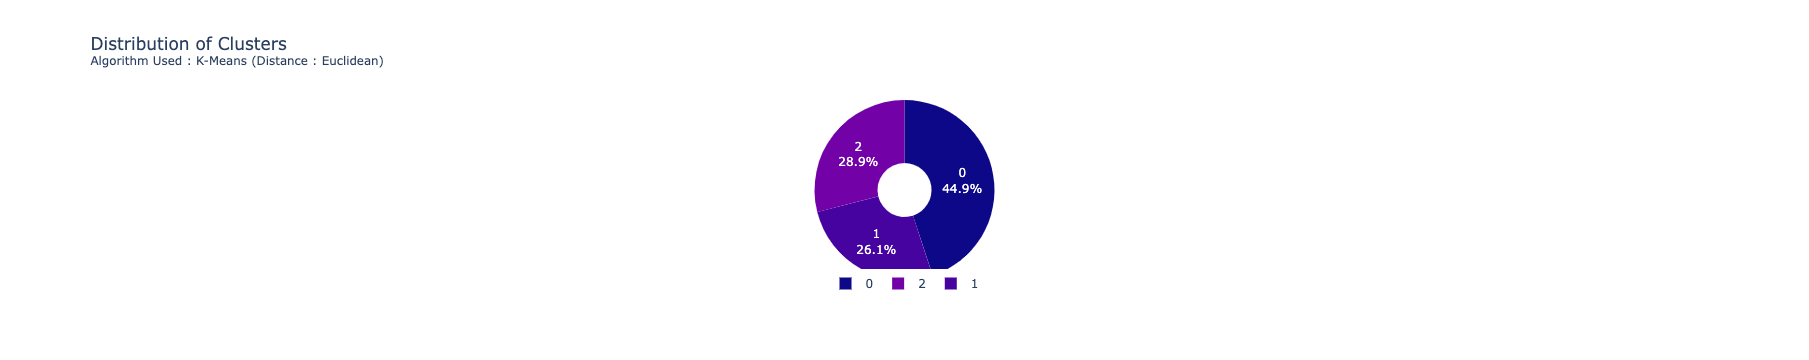

In [25]:
plotly.io.read_json(report_path+"/cluster_plot_2_kmeans_{}".format(lat_cols[0]+"_"+long_cols[0]))

The third plot is a pie-chart showing the cluster information using K-Means algorithm, with K being the optimal K seen in the first plot. We can see that the latitude-longitude are mainly divided into 3 clusters, with almost 45% of the datapoints clustered into cluster 0. Another 26% of datapoints are clustered into cluster 1 and the rest into cluster 2.

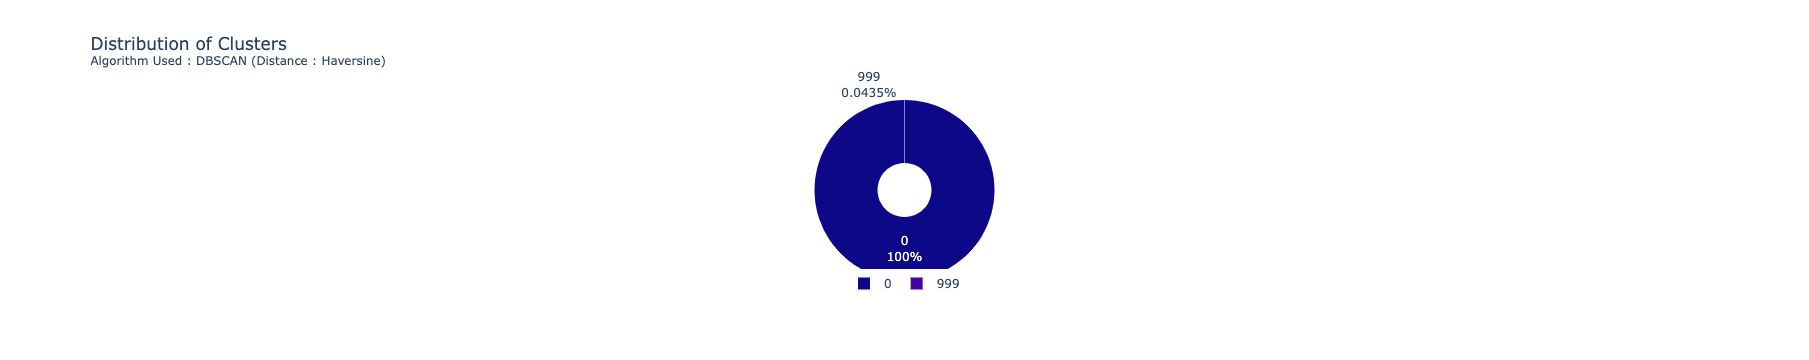

In [26]:
plotly.io.read_json(report_path+"/cluster_plot_2_dbscan_{}".format(lat_cols[0]+"_"+long_cols[0]))

The fourth plot is a pie-chart showing the cluster infrmation using DBSCAN algorithm, with 0 being cluster number and 999 representing noisy samples. We can also see that DBSCAN algorithm does not perform well in sepearting datapoints as ~100% is in cluster 0.

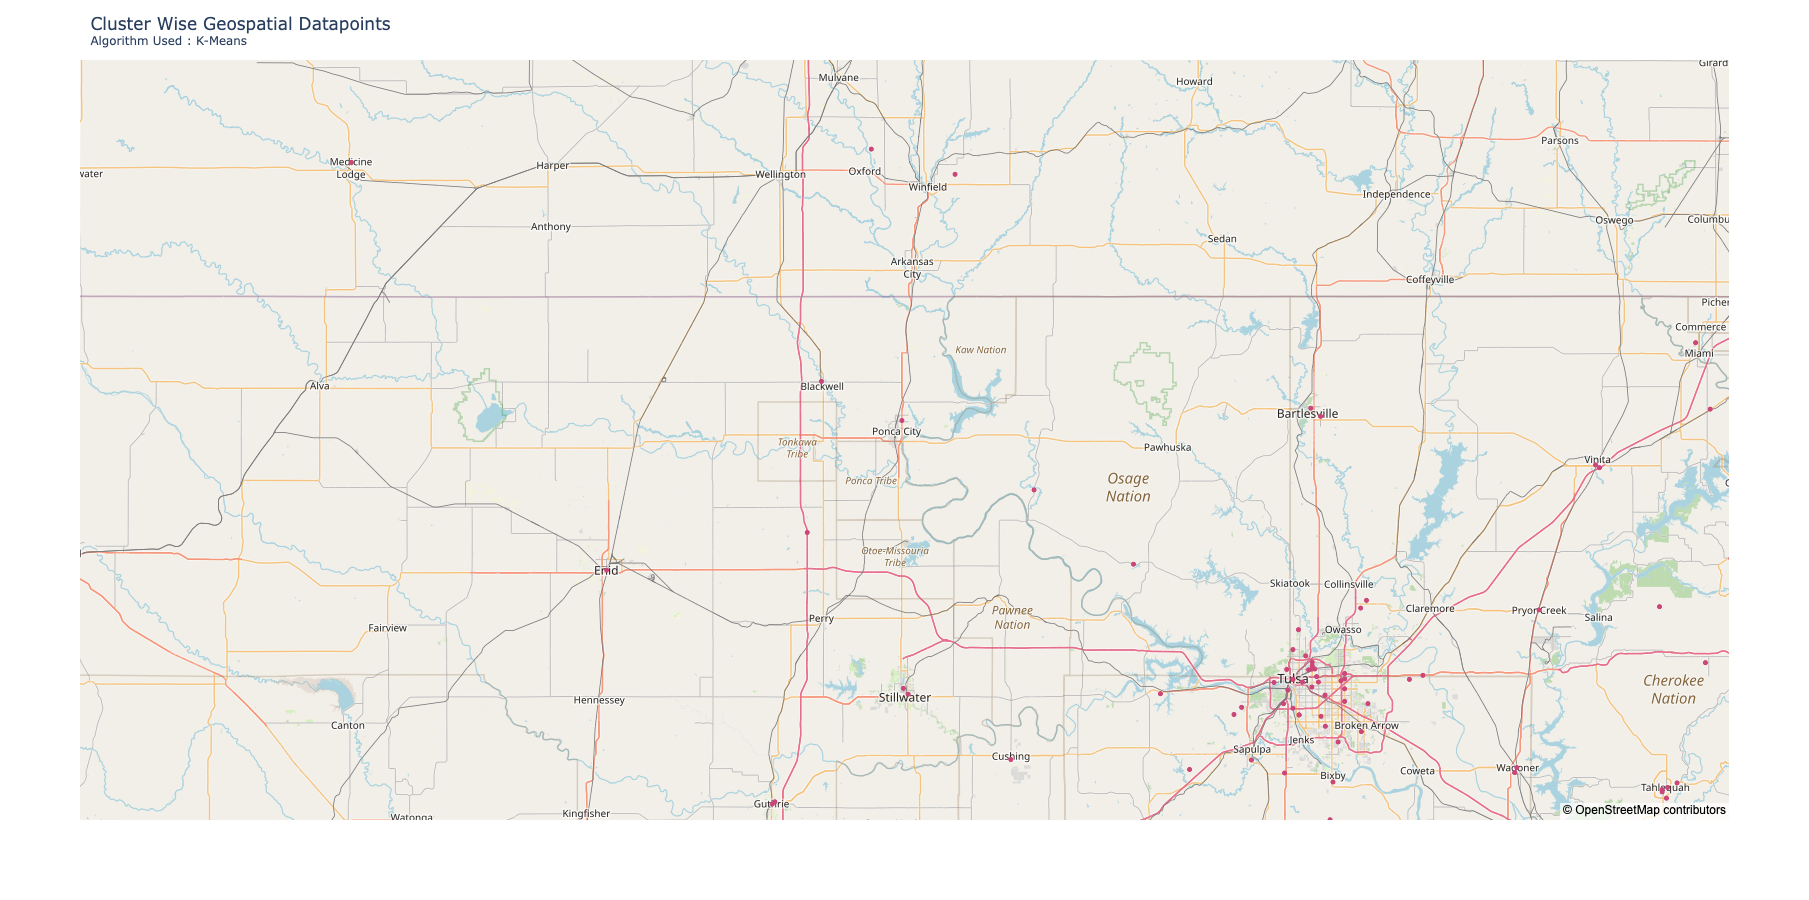

In [27]:
plotly.io.read_json(report_path+"/cluster_plot_3_kmeans_{}".format(lat_cols[0]+"_"+long_cols[0]))

The fifth plot is a Mapbox scatter plot of the datapoints and their assigned clusters using K-Means algorithm. If we zoom-out the map, we can clearly see that the datapoints are classified into 3 clusters.

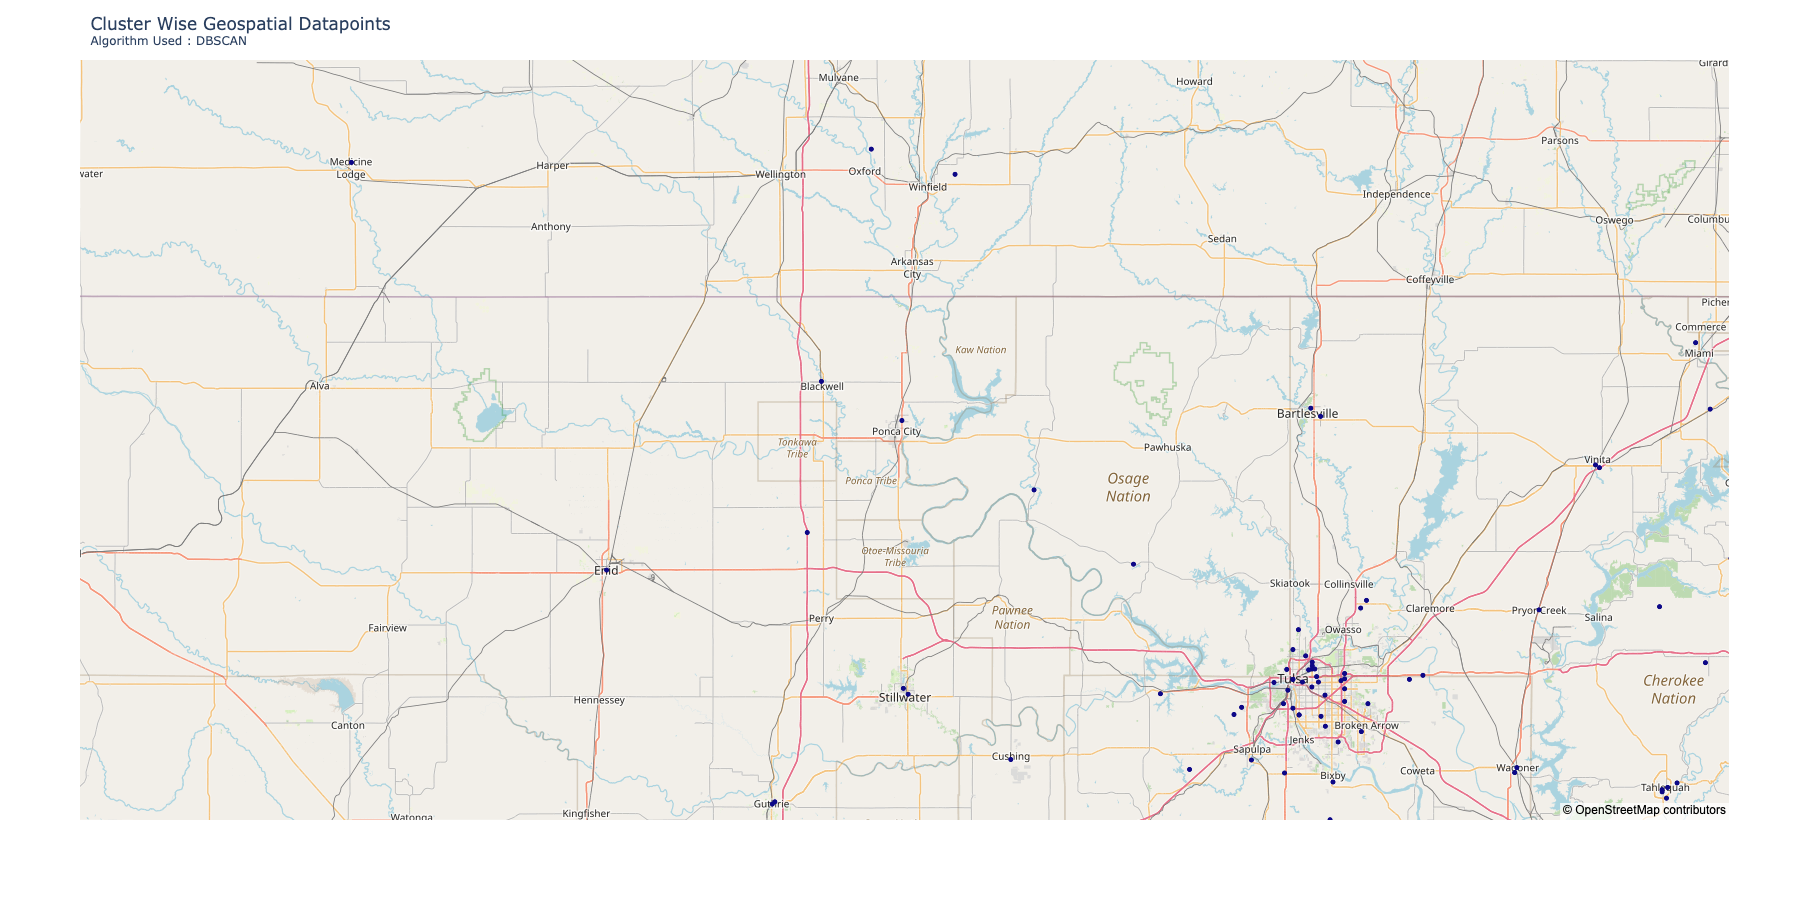

In [28]:
plotly.io.read_json(report_path+"/cluster_plot_3_dbscan_{}".format(lat_cols[0]+"_"+long_cols[0]))

The sixth plot is a Mapbox scatter plot of the datapoints and their assigned clusters using DBSCAN algorithm. By zooming-out, we can see almost all the datapoints are classified into 1 cluster, which agrees with the previous observation from the second and fourth plots.

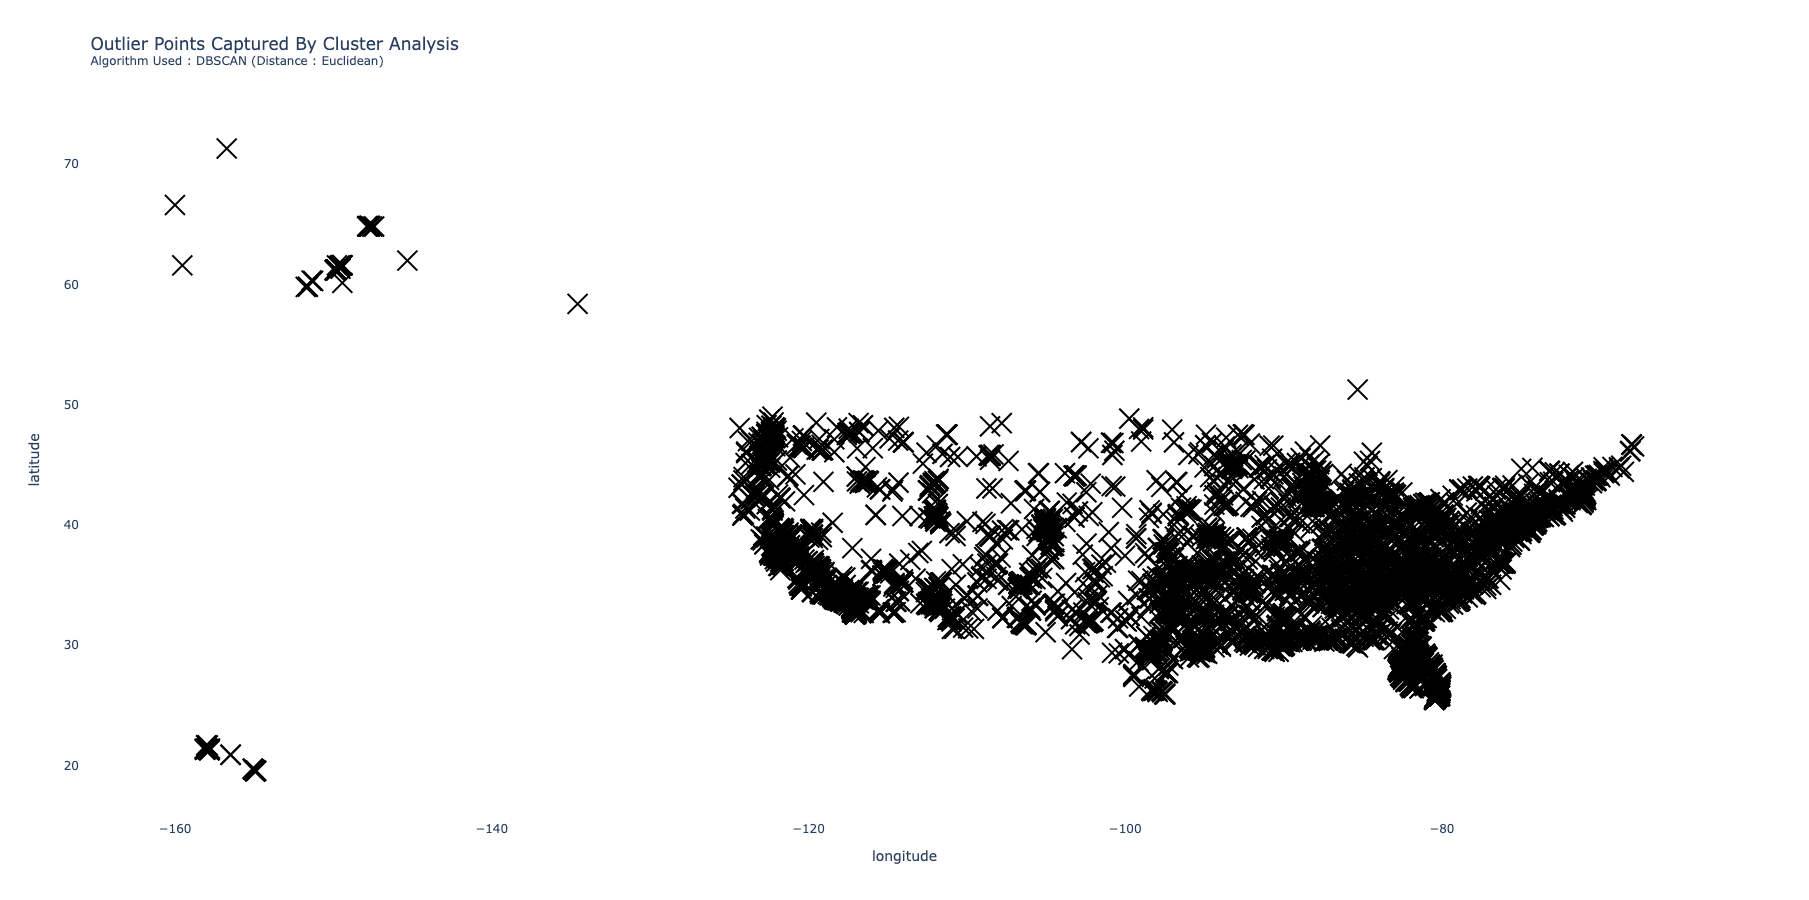

In [29]:
plotly.io.read_json(report_path+"/cluster_plot_4_dbscan_1_{}".format(lat_cols[0]+"_"+long_cols[0]))

The seventh plot is a scatter plot showing outliers captured by DBSCAN algorithm using Euclidean Distance.

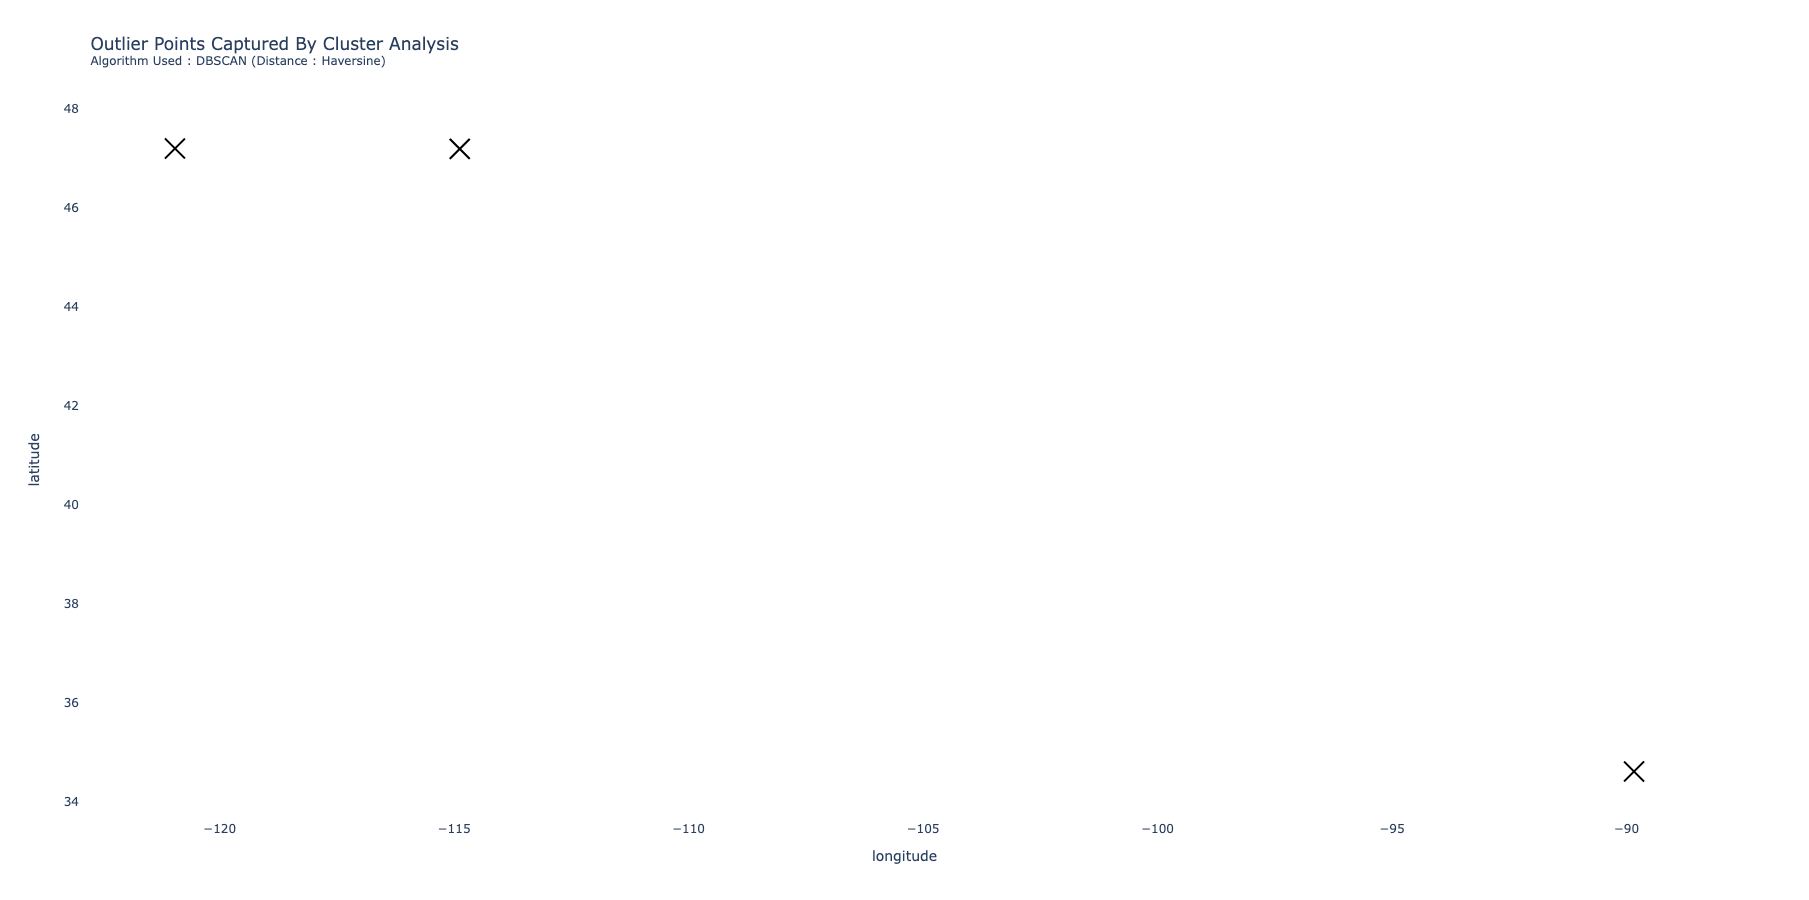

In [30]:
plotly.io.read_json(report_path+"/cluster_plot_4_dbscan_2_{}".format(lat_cols[0]+"_"+long_cols[0]))

The last plot is a scatter plot showing outliers captured by DBSCAN algorithm using Haversine Distance (default setting).

#### Location Visualizations
`generate_loc_charts_controller` generates visualization of all datapoints on a map and stored in JSON format. Each latitude-longitude pair will have 1 plot and each geohash column will have 1.

In [384]:
from anovos.data_analyzer.geospatial_analyzer import generate_loc_charts_controller

In [385]:
generate_loc_charts_controller(df,"id",lat_cols, long_cols, gh_cols, max_records, global_map_box_val, report_path)

Since the dataset does not contain geohash column, only 1 Mapbox scatter plot will be generated and stored in JSON format:
- loc_charts_ll_latitude_longitude

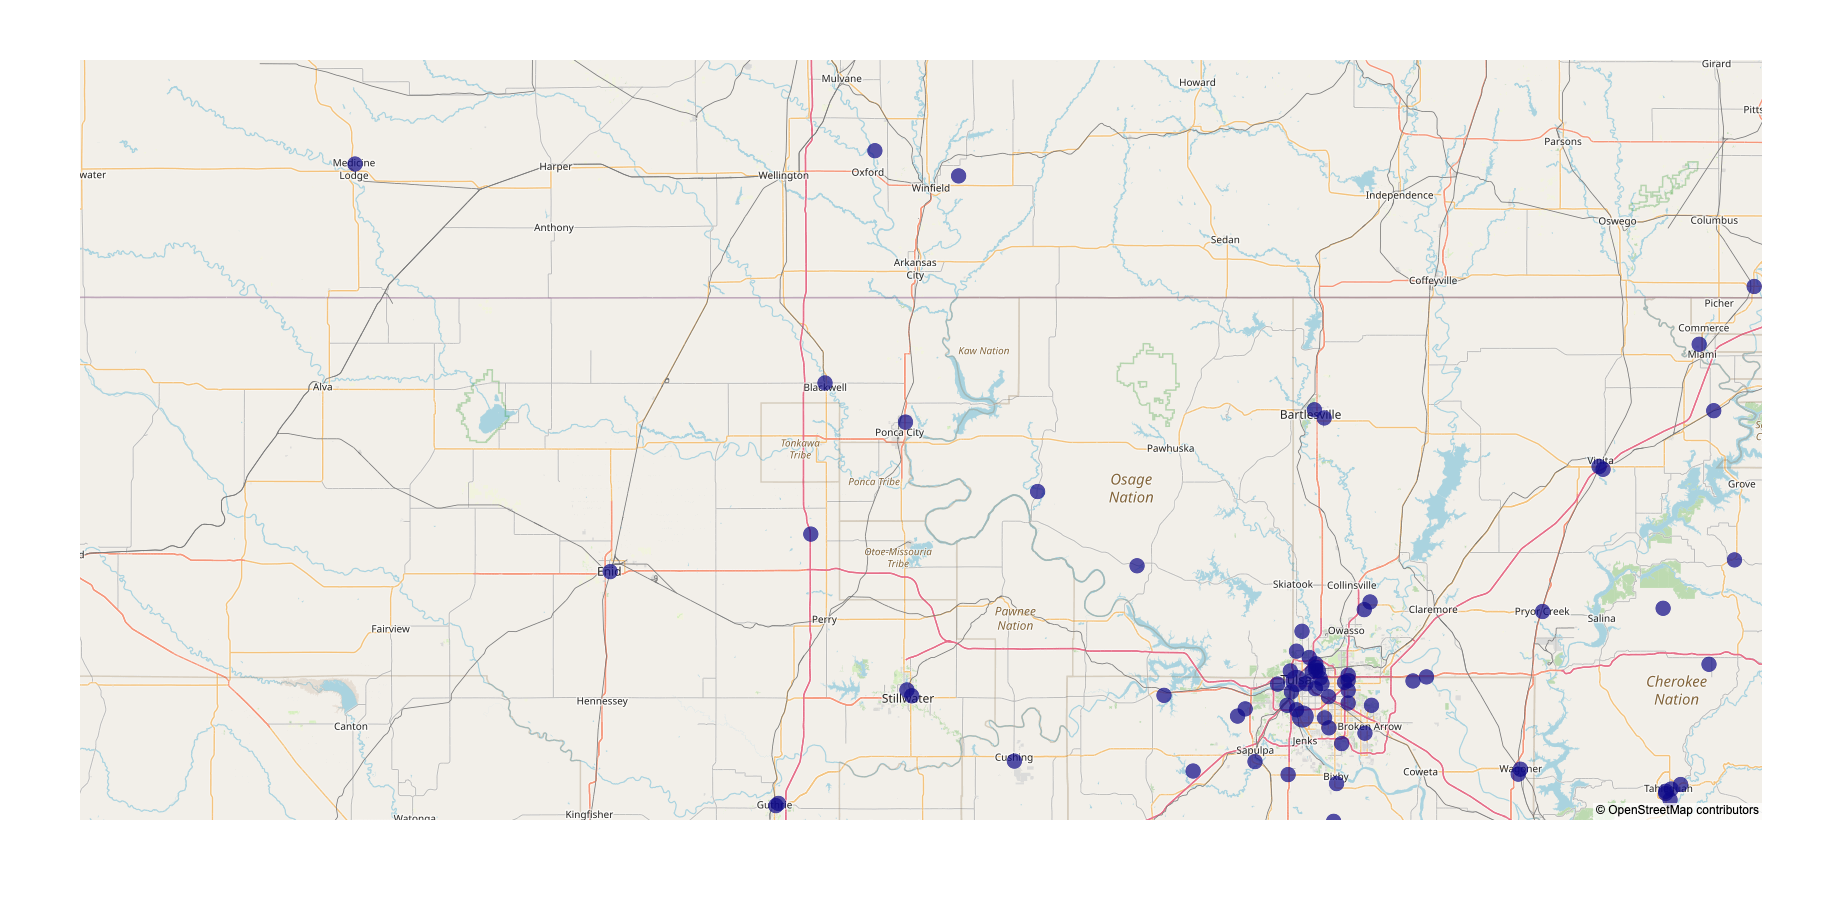

In [33]:
plotly.io.read_json(report_path+"/loc_charts_ll_{}".format(lat_cols[0]+"_"+long_cols[0]))

## Data Transformation
![workflow](assets/img/workflow3.png)
### Cardinality Treatment

We have applied treatment for outliers in numerical features. It is also necessary to perform outlier treatment in categorical features especially when the number of classes within a feature is too large. Using Anovos, we can apply `outlier_categories` provided to limit the number of classes. 

In this example, we use two inputs to control the result: coverage=0.95 and max_category=15. It can be interpreted as top frequently seen categories are considered till it covers minimum 80% of rows and rest lesser seen values are mapped to others. However, maximally 14 categories can be mapped to actual name and rest to others even if the coverage does not reach 95%.

In [387]:
from anovos.data_transformer.transformers import outlier_categories

df = outlier_categories(spark, df, coverage=0.95, max_category=15, 
                        pre_existing_model=False, model_path=output_path, print_impact=True)

+---------------+-------------------+
|attribute      |uniqueValues_before|
+---------------+-------------------+
|manner_of_death|2                  |
|city           |2884               |
|state          |51                 |
|threat_level   |3                  |
|gender         |2                  |
|flee           |4                  |
|race           |6                  |
|armed          |101                |
+---------------+-------------------+

+---------------+------------------+
|attribute      |uniqueValues_after|
+---------------+------------------+
|manner_of_death|2                 |
|city           |15                |
|state          |15                |
|threat_level   |3                 |
|gender         |2                 |
|flee           |4                 |
|race           |4                 |
|armed          |15                |
+---------------+------------------+



### Handle Missing Values
#### Remove columns with > 60% missing values
We can use `nullColumns_detection` to detect and treat columns with high proportion of missing values. In this case, we will let the function delete columns which contain >60% missing values. 

In [389]:
from anovos.data_analyzer.quality_checker import nullColumns_detection
df, odf_stats = nullColumns_detection(spark, df, treatment=True, treatment_method='column_removal', 
                                       treatment_configs={'treatment_threshold':0.6}, print_impact=True)
print(len(df.columns), 'columns are kept.')

+---------+-------------+-----------+
|attribute|missing_count|missing_pct|
+---------+-------------+-----------+
|      age|          381|     0.0553|
|    armed|          197|     0.0286|
|     flee|          702|     0.1019|
|   gender|           16|     0.0023|
|     race|         1067|     0.1548|
+---------+-------------+-----------+

Removed Columns:  []
15 columns are kept.


We can observe the original dataset does not have columns with > 60% missing values.

#### Detect row-wise null values
We can also remove rows with too many missing values using `nullRows_detection`

In [390]:
from anovos.data_analyzer.quality_checker import nullRows_detection
odf, odf_stats = nullRows_detection(spark, df, treatment=False, treatment_threshold=0.4)
odf_stats.toPandas()

null_cols_count  row_count  row_pct  flagged
0                0       5082   0.7374        0
1                1       1344   0.1950        0
2                2        386   0.0560        0
3                3         73   0.0106        0
4                4          7   0.0010        0

We can so no rows are flagged out so we can proceed without treatment.

#### Impute Missing Attributes
We will use `imputation_MMM` to handle missing values. It substitutes null values by the measure of central tendency (mode for categorical features and mean/median for numerical features).

In [411]:
df = imputation_MMM(spark, df, list_of_cols="all", pre_existing_model=False, model_path=output_path)

In [412]:
odf = measures_of_counts(spark, df)
odf.where(F.col('missing_count')>0).toPandas()

Empty DataFrame
Columns: [attribute, fill_count, fill_pct, missing_count, missing_pct, nonzero_count, nonzero_pct]
Index: []

There is no columns with `missing_pct` > 0, which indicates that there is no more missing values in dataframe `df`!

Anovos also supports `auto_imputation` which automatically find the optimal imputation method by evaluating 5 different methodologies. These methodologies can also be used independently by calling their corresponding functions from the transformers module:
* imputation using mean (imputation_MMM with method_type="mean")
* imputation using median (imputation_MMM with method_type="median" )
* imputation using K-Nearest Neighbors algorithm (imputation_sklearn with method_type="KNN")
* imputation using sklearn IterativeImputer (imputation_sklearn with method_type="regression")
* imputation using matrix factorization (imputation_matrixFactorization)

For other imputation methods supported by Anovos, please refer to [transformers documentation](https://docs.anovos.ai/api/data_transformer/transformers.html).

### Categorical Attributes Encoding
Most machine learning models cannot handle catigorical attributes so we need to convert them to numerical attributes. Since our dataset does not have a target column, we will use `cat_to_num_unsupervised` to perform label encoding (default method). Subsequently, we will apply normalization to transform the min and max values for each column to 0 and 1 respectively.

In addition, supervised encoding techniques are also supported by function `cat_to_num_supervised`.

In [415]:
from anovos.shared.utils import attributeType_segregation
cat_cols = attributeType_segregation(df)[1]

from anovos.data_transformer.transformers import cat_to_num_unsupervised
df_model = cat_to_num_unsupervised(spark, df, pre_existing_model=False, model_path=output_path, 
                                 print_impact=False)

from anovos.data_transformer.transformers import normalization
df_model = normalization(df_model, list_of_cols=cat_cols, pre_existing_model=False, 
                         model_path=output_path+'normalization_cat/')

df_model.select(cat_cols).describe().toPandas()

summary      manner_of_death                  city               state  \
0   count                 6892                  6892                6892   
1    mean  0.04730121880441091  0.048430893346407836  0.2291373044438336   
2  stddev  0.21229779325583623    0.1682338622288049  0.2885648877801267   
3     min                  0.0                   0.0                 0.0   
4     max                  1.0                   1.0                 1.0   

          threat_level               gender                 flee  \
0                 6892                 6892                 6892   
1  0.20139291932675565  0.04628554846198491  0.17396982417193804   
2  0.27979578450992765  0.21011806772815003  0.28370141657522674   
3                  0.0                  0.0                  0.0   
4                  1.0                  1.0                  1.0   

                  race                armed  
0                 6892                 6892  
1  0.21362933401478906  0.09500663489907617  
2  0.28878537150544104  0.17024080313421677  
3                  0.0                  0.0  
4                  1.0                  1.0

### Geospatial Fields Transformation

`geospatial` module supports transformation & calculation functions for geospatial fields, such as transforming between different formats, controlling geohash values precisions, checking if a location is inside a country, calculating centroid and Radius of Gyration, and reverse latitude-longitude pairs into address. Functions supported through this module are listed below:
- geo_format_latlon
- geo_format_cartesian
- geo_format_geohash
- location_distance
- geohash_precision_control
- location_in_polygon
- location_in_country
- centroid
- weighted_centroid
- rog_calculation
- reverse_geocoding

In this section, we will demonstrate a few of these techniques to showcase their functionalities.

#### Transform Latitude-Longitude Format

In [34]:
from anovos.data_transformer.geospatial import geo_format_latlon

In [39]:
odf = geo_format_latlon(df.select(lat_cols+long_cols), lat_cols, long_cols, "dd", output_format="cartesian", result_prefix="transformed")
odf.toPandas().head()

latitude  longitude  transformed_x  transformed_y  transformed_z
0    47.247   -123.122   -2363222.250    -3622134.75     4678149.00
1    45.487   -122.892   -2425581.500    -3750526.25     4543111.50
2    37.695    -97.281    -638904.000    -5000582.50     3895604.25
3    37.763   -122.422   -2700380.750    -4251510.00     3901584.75
4    40.384   -104.692   -1230811.625    -4694245.00     4127822.75

We can transform latitude-longitude information into other formats by specifying `output_format`

`geo_format_latlon` also supports transformation into below formats:
- `dms`: latitude and longitude in degrees minutes second
- `radian`: latitude and longitude in radians
- `geohash`: geocoded locations

#### Location in Country

In [44]:
from anovos.data_transformer.geospatial import location_in_country
import pyspark.sql.functions as F

In [45]:
# Example - check if any datapoints are in US
odf = location_in_country(spark, df, lat_cols, long_cols, "US", result_prefix="location")
odf.filter(F.col("location_in_US_approx")==1).toPandas()

id   manner_of_death        armed   age gender  race  \
0        1              shot          gun  53.0      M     A   
1        2              shot          gun  47.0      M     W   
2        3  shot and Tasered      unarmed  23.0      M     H   
3        4              shot   toy weapon  32.0      M     W   
4        5              shot     nail gun  39.0      M     H   
...    ...               ...          ...   ...    ...   ...   
6809  7724              shot          gun   NaN      M  None   
6810  7725              shot  screwdriver   NaN      M  None   
6811  7726              shot          gun   NaN      M     W   
6812  7727              shot        knife  61.0      M     B   
6813  7728              shot          gun  27.0      M  None   

                   city state  signs_of_mental_illness threat_level  \
0               Shelton    WA                     True       attack   
1                 Aloha    OR                    False       attack   
2               Wichita    KS                    False        other   
3         San Francisco    CA                     True       attack   
4                 Evans    CO                    False       attack   
...                 ...   ...                      ...          ...   
6809    Strongs Prairie    WI                    False        other   
6810          Flagstaff    AZ                    False        other   
6811        Springville    AL                    False       attack   
6812          St. Louis    MO                    False        other   
6813  Washington County    TN                    False       attack   

             flee  body_camera  longitude  latitude  is_geocoding_exact  \
0     Not fleeing        False   -123.122    47.247                True   
1     Not fleeing        False   -122.892    45.487                True   
2     Not fleeing        False    -97.281    37.695                True   
3     Not fleeing        False   -122.422    37.763                True   
4     Not fleeing        False   -104.692    40.384                True   
...           ...          ...        ...       ...                 ...   
6809  Not fleeing         True    -89.944    44.025                True   
6810         Foot        False   -111.584    35.224                True   
6811          Car        False    -86.472    33.775                True   
6812  Not fleeing        False    -90.290    38.668                True   
6813        Other        False    -82.539    36.309                True   

      location_in_US_approx  
0                         1  
1                         1  
2                         1  
3                         1  
4                         1  
...                     ...  
6809                      1  
6810                      1  
6811                      1  
6812                      1  
6813                      1  

[6814 rows x 16 columns]

We can see 6814 datapoints are inside US.

#### Centroid Calculation

In [47]:
from anovos.data_transformer.geospatial import centroid

In [54]:
odf = centroid(df, lat_cols[0], long_cols[0])
odf.toPandas()

lat_centroid  long_centroid
0     37.802717     -96.753609

`centroid` allows us to calculate the overall centroid of the entrie dataframe.

#### ROG Calculation

In [62]:
from anovos.data_transformer.geospatial import rog_calculation

In [65]:
odf = rog_calculation(df, lat_cols[0], long_cols[0], id_col=None)
odf.toPandas()

radius_of_gyration
0        1.399527e+06

By setting `id_col=None`, `rog_calculation` calculates the Radius of Gyration (in meter) of the entire DataFrame.

In [66]:
odf = rog_calculation(df, lat_cols[0], long_cols[0], id_col=id_col)
odf.toPandas()

id  radius_of_gyration
0      148            0.286316
1      463            0.165473
2      471            0.305913
3      496            0.182109
4      833            0.143597
...    ...                 ...
6887  6721            0.238403
6888  6819            0.068323
6889  7166            0.149723
6890  7466            0.158863
6891  7476            0.232780

[6892 rows x 2 columns]

Specifying `id_col` allows `rog_calculation` to calculate the Radius of Gyration (in meter) of the datapoints based on `id_col`.

#### Reverse Geo-coding

In [67]:
from anovos.data_transformer.geospatial import reverse_geocoding

In [69]:
odf = reverse_geocoding(df, lat_cols[0], long_cols[0])
odf.toPandas()

latitude  longitude  name_of_place      region country_code
0       47.247   -123.122        Shelton  Washington           US
1       45.487   -122.892          Aloha      Oregon           US
2       37.695    -97.281        Wichita      Kansas           US
3       37.763   -122.422  San Francisco  California           US
4       40.384   -104.692          Evans    Colorado           US
...        ...        ...            ...         ...          ...
6887    44.025    -89.944     Friendship   Wisconsin           US
6888    35.224   -111.584      Flagstaff     Arizona           US
6889    33.775    -86.472    Springville     Alabama           US
6890    38.668    -90.290       Wellston    Missouri           US
6891    36.309    -82.539   Jonesborough   Tennessee           US

[6892 rows x 5 columns]

`reverse_geocoding` can decode geospatial fields from latitude, longitude to address information, including `name_of_place`, `region`, and `country_code`.

## Summary
We have demonstrated how to use Anovos to analyze dataset containing geospatial information, including descriptive statistics, clustering, visualizations and transformations.